In [21]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [22]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [23]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [24]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [25]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [26]:
# 36通りの組み合わせを生成
permutations = list(itertools.product(itertools.permutations([0, 1, 2]), repeat=2))

# 最適化のためのobjective関数
def objective(trial, perm1, perm2):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', -180.0, 180.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm1, perm2 in permutations:
    print(f"Evaluating combination: perm1={perm1}, perm2={perm2}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm1, perm2), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm1}, perm2={perm2}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
        k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
        k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

        optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4, k5, k6]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [t1, t2]:
                    param.data = torch.clamp(param.data, 0.0, 180.0)
                for param in [p1, p2]:
                    param.data = torch.clamp(param.data, -180.0, 180.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm1, perm2)

        print(f"Finished training for combination: perm1={perm1}, perm2={perm2}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-11-06 14:51:40,703] A new study created in memory with name: no-name-f3be9a3e-3efa-4da5-aec0-ca4829fb3247


Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-06 14:51:40,936] Trial 0 finished with value: 412.7858581542969 and parameters: {'k1': 9.883686076056467, 'k2': -9.97520622163557, 'k3': 4.602315410039722, 'k4': 7.447717302727767, 'k5': 7.214951544974955, 'k6': -1.7268885807833794, 't1': 138.83229216799523, 'p1': -115.24265858034519, 't2': 104.71396373393357, 'p2': 98.7109801469735}. Best is trial 0 with value: 412.7858581542969.
[I 2024-11-06 14:51:40,984] Trial 1 finished with value: 350.8269958496094 and parameters: {'k1': -7.431005301621958, 'k2': -0.018107024881789613, 'k3': 2.186423901151443, 'k4': 3.380376032109492, 'k5': 5.544469075729978, 'k6': -4.695834134040924, 't1': 120.70574301444431, 'p1': 172.1103346596126, 't2': 110.76677635833643, 'p2': -52.175529842242085}. Best is trial 1 with value: 350.8269958496094.
[I 2024-11-06 14:51:41,032] Trial 2 finished with value: 421.78094482421875 and parameters: {'k1': -2.1332135768161598, 'k2': 6.704532692923973, 'k3': 5.181409989374931, 'k4': 5.609524131180425, 'k5': 4.30

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 27.55544090270996
Parameters: k1=-1.5189913511276245, k2=-9.4506254196167, k3=-0.19449730217456818, k4=-0.36614111065864563, k5=8.055828094482422, k6=-2.5818724632263184, t1=73.10711669921875, p1=-153.9925079345703, t2=34.476558685302734, p2=169.66722106933594
Epoch 100, Loss: 9.859224319458008
Parameters: k1=2.9160959720611572, k2=-10.0, k3=-3.1186468601226807, k4=0.3162941336631775, k5=9.05256462097168, k6=-2.833423614501953, t1=67.11536407470703, p1=-157.14866638183594, t2=38.67582702636719, p2=168.65943908691406
Epoch 200, Loss: 9.557594299316406
Parameters: k1=2.941505193710327, k2=-10.0, k3=-3.2300522327423096, k4=0.2339654564857483, k5=9.31583023071289, k6=-3.393812656402588, t1=67.10691833496094, p1=-161.11614990234375, t2=40.487548828125, p2=167.34564208984375
Epoch 300, Loss: 9.25787353515625
Parameters: k1=2.8573780059814453, k2=-10.0, k3=-3.247631072998047, k4=-0.1287592649459839, k5=9.637115

[I 2024-11-06 14:53:25,328] A new study created in memory with name: no-name-17fc7292-9d16-4590-b174-e16847641fbd
[I 2024-11-06 14:53:25,433] Trial 0 finished with value: 176.80458068847656 and parameters: {'k1': 0.19899304724589406, 'k2': 7.739645782107253, 'k3': -2.056046235693964, 'k4': 7.371388626413882, 'k5': -4.30329562470849, 'k6': -1.0918828865778902, 't1': 13.859961657689105, 'p1': -95.25275884815152, 't2': 12.937073823702612, 'p2': 76.10960966103028}. Best is trial 0 with value: 176.80458068847656.
[I 2024-11-06 14:53:25,480] Trial 1 finished with value: 166.77682495117188 and parameters: {'k1': 3.6360087807800507, 'k2': -1.2782906110852075, 'k3': -5.57224887954376, 'k4': 3.912574904693633, 'k5': 2.2844660743142136, 'k6': 7.149906770801952, 't1': 44.39304299100829, 'p1': 107.52544194095935, 't2': 121.34518299449657, 'p2': -31.752645605504995}. Best is trial 1 with value: 166.77682495117188.
[I 2024-11-06 14:53:25,528] Trial 2 finished with value: 441.8908996582031 and paramet

Loss increased at epoch 853. Stopping training.
Best params during epoch training: {'k1': 1.9607229232788086, 'k2': -9.509018898010254, 'k3': -3.279757499694824, 'k4': -2.674060821533203, 'k5': 10.0, 'k6': -9.355234146118164, 't1': 60.52461624145508, 'p1': -180.0, 't2': 38.7629280090332, 'p2': 152.44155883789062}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 2, 1)


[I 2024-11-06 14:53:25,578] Trial 3 finished with value: 157.82464599609375 and parameters: {'k1': -1.9264606265686783, 'k2': -8.04421978752756, 'k3': -2.4691583678860702, 'k4': -0.6433865545580009, 'k5': 6.263378849617837, 'k6': -6.277331824181466, 't1': 18.93308553629352, 'p1': -90.34026324571538, 't2': 122.94180576813415, 'p2': -143.34349588242674}. Best is trial 3 with value: 157.82464599609375.
[I 2024-11-06 14:53:25,628] Trial 4 finished with value: 319.2490234375 and parameters: {'k1': -3.4224251231814895, 'k2': 2.7420563057381138, 'k3': 6.689352003325631, 'k4': -7.153084883595229, 'k5': -5.695873260873807, 'k6': -6.359297942097006, 't1': 117.20670124105344, 'p1': 78.36887645251346, 't2': 103.22510540220428, 'p2': 153.05612659577946}. Best is trial 3 with value: 157.82464599609375.
[I 2024-11-06 14:53:25,676] Trial 5 finished with value: 334.7354736328125 and parameters: {'k1': 9.119010410989492, 'k2': -9.895154883978694, 'k3': -6.015314772286098, 'k4': -1.7012902410259656, 'k5'

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Epoch 0 Loss is 41.202884674072266, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 0, 2)


[I 2024-11-06 14:53:59,633] Trial 3 finished with value: 690.833740234375 and parameters: {'k1': -4.178097468543043, 'k2': 2.9199973897559968, 'k3': 7.504570565485334, 'k4': 9.669351564089538, 'k5': -0.13413477019502196, 'k6': 2.912015616544135, 't1': 26.00960486318049, 'p1': 97.91434956169331, 't2': 165.55428596346414, 'p2': 105.89672690616942}. Best is trial 1 with value: 279.8360290527344.
[I 2024-11-06 14:53:59,742] Trial 4 finished with value: 456.4073486328125 and parameters: {'k1': -5.50265238620481, 'k2': 5.526061038519071, 'k3': 1.5518817146695838, 'k4': -7.460438113228118, 'k5': 5.911869085168046, 'k6': -6.996085049030889, 't1': 94.73164868976745, 'p1': -45.808035395399656, 't2': 89.33305238797834, 'p2': 140.36479872338316}. Best is trial 1 with value: 279.8360290527344.
[I 2024-11-06 14:53:59,787] Trial 5 finished with value: 136.04696655273438 and parameters: {'k1': -8.465567511675536, 'k2': 7.708880374913239, 'k3': -4.358872476535732, 'k4': -0.4199323312007497, 'k5': 4.723

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Epoch 0, Loss: 30.664825439453125
Parameters: k1=-9.5072660446167, k2=-1.0882288217544556, k3=-3.3526649475097656, k4=7.751499652862549, k5=4.61176061630249, k6=7.988123893737793, t1=175.4654083251953, p1=12.919733047485352, t2=163.80604553222656, p2=2.3868534564971924
Epoch 100, Loss: 17.363788604736328
Parameters: k1=-10.0, k2=7.046993255615234, k3=-4.066555500030518, k4=5.736043453216553, k5=4.413604259490967, k6=10.0, t1=180.0, p1=16.8924617767334, t2=159.66854858398438, p2=-4.871433734893799
Epoch 200, Loss: 17.324796676635742
Parameters: k1=-10.0, k2=8.118003845214844, k3=-4.147022247314453, k4=5.836581230163574, k5=4.443210601806641, k6=10.0, t1=180.0, p1=16.894378662109375, t2=159.96011352539062, p2=-4.76414155960083
Epoch 300, Loss: 17.31884002685547
Parameters: k1=-10.0, k2=8.554441452026367, k3=-4.176279067993164, k4=5.903468132019043, k5=4.431228160858154, k6=10.0, t1=180.0, p1=16.894378662109375, t2=160.11

[I 2024-11-06 14:55:11,231] A new study created in memory with name: no-name-5c52b6df-0013-4acf-9778-79fea74e7e85
[I 2024-11-06 14:55:11,279] Trial 0 finished with value: 177.9398193359375 and parameters: {'k1': 3.7168839229743718, 'k2': 4.976887155085183, 'k3': -9.619751724656622, 'k4': 3.957363627537024, 'k5': -0.04559409292388139, 'k6': 6.063344339028667, 't1': 123.56246698879443, 'p1': 3.5710683681049034, 't2': 25.587401641874997, 'p2': -144.4473307009577}. Best is trial 0 with value: 177.9398193359375.
[I 2024-11-06 14:55:11,324] Trial 1 finished with value: 448.6632995605469 and parameters: {'k1': -5.233186177743705, 'k2': -0.9020621436253666, 'k3': 0.9176584406729393, 'k4': -1.424569751768729, 'k5': 9.110939623388848, 'k6': 5.8885721832478595, 't1': 3.541055647151843, 'p1': 79.25383675685276, 't2': 119.28168656722116, 'p2': 61.70327589053801}. Best is trial 0 with value: 177.9398193359375.
[I 2024-11-06 14:55:11,369] Trial 2 finished with value: 535.8006591796875 and parameters:

Loss increased at epoch 470. Stopping training.
Best params during epoch training: {'k1': -10.0, 'k2': 8.829103469848633, 'k3': -4.193927764892578, 'k4': 5.946485996246338, 'k5': 4.425724983215332, 'k6': 10.0, 't1': 180.0, 'p1': 16.894378662109375, 't2': 160.21542358398438, 'p2': -4.050030708312988}
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 2, 0)


[I 2024-11-06 14:55:11,517] Trial 4 finished with value: 120.69371032714844 and parameters: {'k1': 8.730928534669896, 'k2': 9.340525410301098, 'k3': -5.040877538318382, 'k4': 1.3684566477517546, 'k5': -4.756676458334182, 'k6': -8.769954925233364, 't1': 11.437019015179278, 'p1': 101.49991578076248, 't2': 157.36263222811976, 'p2': -33.936093824476444}. Best is trial 4 with value: 120.69371032714844.
[I 2024-11-06 14:55:11,572] Trial 5 finished with value: 333.98883056640625 and parameters: {'k1': -1.7441972147138642, 'k2': 6.46068117082217, 'k3': -5.62626104776321, 'k4': -4.0181576682588, 'k5': -3.4050900799862553, 'k6': 3.2496781686146665, 't1': 28.15591596785932, 'p1': 12.283097062917847, 't2': 92.9386884544898, 'p2': 62.19378065561099}. Best is trial 4 with value: 120.69371032714844.
[I 2024-11-06 14:55:11,619] Trial 6 finished with value: 404.7218933105469 and parameters: {'k1': -9.501463817667116, 'k2': 3.2275011176748656, 'k3': 7.193969879652965, 'k4': 4.121482924698521, 'k5': -5.3

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Epoch 0 Loss is 54.09685134887695, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 0, 1)


[I 2024-11-06 14:55:43,868] Trial 2 finished with value: 222.24884033203125 and parameters: {'k1': 2.977368291332116, 'k2': -8.256980156675969, 'k3': -2.7503392880664084, 'k4': 3.6698632110689076, 'k5': 4.449385226212524, 'k6': 3.103359755209933, 't1': 9.255883648125431, 'p1': -83.22614257056027, 't2': 146.97379433246374, 'p2': 20.976916984646493}. Best is trial 2 with value: 222.24884033203125.
[I 2024-11-06 14:55:43,915] Trial 3 finished with value: 959.8728637695312 and parameters: {'k1': 7.859652862163173, 'k2': -6.688918264455719, 'k3': 9.484821789166766, 'k4': -3.881772366996657, 'k5': 7.276102994582956, 'k6': -9.91136102570086, 't1': 93.10060451625206, 'p1': 127.51202176521548, 't2': 151.36705039554832, 'p2': -146.39446194799137}. Best is trial 2 with value: 222.24884033203125.
[I 2024-11-06 14:55:43,960] Trial 4 finished with value: 377.4725646972656 and parameters: {'k1': -8.232528162080147, 'k2': 0.9573468451287113, 'k3': 2.574085087680391, 'k4': 0.015017055723776096, 'k5': 3

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Epoch 0 Loss is 41.6549186706543, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 1, 0)


[I 2024-11-06 14:56:16,219] Trial 2 finished with value: 359.24029541015625 and parameters: {'k1': -4.750385551444181, 'k2': -6.151926899423121, 'k3': 5.770074356163267, 'k4': 4.136626538272692, 'k5': -5.043178185945987, 'k6': -5.132214889253717, 't1': 156.52462173842937, 'p1': -84.52866258188165, 't2': 109.33681289324613, 'p2': -109.64736588749844}. Best is trial 0 with value: 216.61734008789062.
[I 2024-11-06 14:56:16,299] Trial 3 finished with value: 693.1629028320312 and parameters: {'k1': 9.736785411012946, 'k2': 8.775213450169904, 'k3': -5.819369909653513, 'k4': 9.100759350622585, 'k5': -6.2233683503611985, 'k6': 9.801924547418587, 't1': 100.97599141119332, 'p1': -171.15827784112435, 't2': 176.84570744633763, 'p2': 119.97088033512188}. Best is trial 0 with value: 216.61734008789062.
[I 2024-11-06 14:56:16,344] Trial 4 finished with value: 146.26309204101562 and parameters: {'k1': -4.372734251875274, 'k2': -3.0747717247083406, 'k3': -1.386361943995908, 'k4': 5.715445090012043, 'k5

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 40.8189811706543, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 1, 2)


[I 2024-11-06 14:56:49,065] Trial 3 finished with value: 160.10948181152344 and parameters: {'k1': 1.1394782845681384, 'k2': -7.03281235646916, 'k3': 7.156599957022799, 'k4': -7.672263799419714, 'k5': 6.856593464636585, 'k6': 3.1538185576715723, 't1': 138.088538361394, 'p1': -99.72440241668657, 't2': 89.77932212691307, 'p2': -48.5512240817817}. Best is trial 3 with value: 160.10948181152344.
[I 2024-11-06 14:56:49,150] Trial 4 finished with value: 95.52569580078125 and parameters: {'k1': -7.094134878615086, 'k2': -2.223010281742976, 'k3': -2.1783063260948925, 'k4': 2.4385961790792763, 'k5': 5.830917422806836, 'k6': -5.162109046727035, 't1': 18.81582890269852, 'p1': 70.45302048268167, 't2': 26.28055370051628, 'p2': -153.1929564969248}. Best is trial 4 with value: 95.52569580078125.
[I 2024-11-06 14:56:49,251] Trial 5 finished with value: 464.78070068359375 and parameters: {'k1': 0.03455611713107487, 'k2': 5.486090669276853, 'k3': 0.6047778602067488, 'k4': -0.45829333251635695, 'k5': 9.7

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Epoch 0, Loss: 33.60810852050781
Parameters: k1=1.1791516542434692, k2=-3.395883560180664, k3=-4.007761478424072, k4=-6.601477146148682, k5=-7.409617900848389, k6=2.5619702339172363, t1=54.05879211425781, p1=-49.43156433105469, t2=146.34835815429688, p2=-139.58387756347656
Epoch 100, Loss: 8.02026653289795
Parameters: k1=1.2486720085144043, k2=0.3446919620037079, k3=-4.706864356994629, k4=-5.516246795654297, k5=-4.792817115783691, k6=5.582492351531982, t1=50.157936096191406, p1=-57.04641342163086, t2=139.28993225097656, p2=-135.87327575683594
Epoch 200, Loss: 7.614066123962402
Parameters: k1=0.7774584889411926, k2=0.7795943021774292, k3=-4.756110668182373, k4=-5.57695198059082, k5=-4.582904815673828, k6=5.4762864112854, t1=53.13860321044922, p1=-58.57686996459961, t2=139.22772216796875, p2=-134.27781677246094
Epoch 300, Loss: 7.15708589553833
Parameters: k1=0.2952919602394104, k2=1.0545634031295776, k3=-4.7677979469299

[I 2024-11-06 14:59:17,605] A new study created in memory with name: no-name-8687cf79-fb10-4efa-8d0c-75c1aeb387ed
[I 2024-11-06 14:59:17,652] Trial 0 finished with value: 189.78662109375 and parameters: {'k1': 1.5130707877469174, 'k2': 7.485562489758017, 'k3': -9.785701768305762, 'k4': -3.826099896579393, 'k5': -5.12296172775536, 'k6': -1.7139583857907166, 't1': 39.56093458845412, 'p1': -70.12283914051743, 't2': 5.9230376519151795, 'p2': -146.01534873943194}. Best is trial 0 with value: 189.78662109375.
[I 2024-11-06 14:59:17,700] Trial 1 finished with value: 168.47409057617188 and parameters: {'k1': -6.765743662676247, 'k2': -5.59210819244443, 'k3': -6.861403140105232, 'k4': 7.04728415304854, 'k5': -2.3954984063697733, 'k6': -1.8254707568656965, 't1': 106.11945125034924, 'p1': -105.66880211020546, 't2': 50.35288277245852, 'p2': 25.760926100854107}. Best is trial 1 with value: 168.47409057617188.
[I 2024-11-06 14:59:17,746] Trial 2 finished with value: 240.85342407226562 and parameters

Loss increased at epoch 1363. Stopping training.
Best params during epoch training: {'k1': -1.1333357095718384, 'k2': 0.941386342048645, 'k3': -4.4909820556640625, 'k4': -6.218862533569336, 'k5': -3.924060821533203, 'k6': 4.86362886428833, 't1': 75.96672058105469, 'p1': -64.18978118896484, 't2': 143.5487823486328, 'p2': -127.99031829833984}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-06 14:59:17,898] Trial 4 finished with value: 219.35728454589844 and parameters: {'k1': 7.711733967931487, 'k2': -8.56362955613831, 'k3': -1.7291684150006184, 'k4': 8.717899714781186, 'k5': 4.620610014491099, 'k6': 8.453533522472206, 't1': 154.20215054363803, 'p1': -116.67135714475711, 't2': 163.2418458874593, 'p2': -110.38733423632205}. Best is trial 3 with value: 103.46731567382812.
[I 2024-11-06 14:59:17,945] Trial 5 finished with value: 351.7851867675781 and parameters: {'k1': -0.3976190902609673, 'k2': 8.497291345580823, 'k3': 3.0547299251025315, 'k4': 4.215306894655111, 'k5': 5.307487048348399, 'k6': -6.078658181839824, 't1': 135.14031469935057, 'p1': 73.69664335448502, 't2': 9.198928219597871, 'p2': 10.230617760540753}. Best is trial 3 with value: 103.46731567382812.
[I 2024-11-06 14:59:17,993] Trial 6 finished with value: 257.513427734375 and parameters: {'k1': 6.110298433879112, 'k2': 6.604200001311579, 'k3': -8.899248535426477, 'k4': -5.283549752641868, 'k5': -3.35

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0 Loss is 61.82077407836914, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 0, 2)


[I 2024-11-06 14:59:50,306] Trial 3 finished with value: 843.997802734375 and parameters: {'k1': 6.195779405358163, 'k2': 4.646553531181084, 'k3': 8.089622022182827, 'k4': 3.7154047060076003, 'k5': 8.72432512129686, 'k6': 0.3108982717911051, 't1': 128.43696953680725, 'p1': -168.63733302805707, 't2': 136.17058863760738, 'p2': 93.85341016079104}. Best is trial 0 with value: 249.8166046142578.
[I 2024-11-06 14:59:50,386] Trial 4 finished with value: 314.5208740234375 and parameters: {'k1': -7.758870323544036, 'k2': -5.500671768819845, 'k3': -6.78110009966427, 'k4': -5.303681628418941, 'k5': -1.7484656243806, 'k6': 7.68644067675887, 't1': 93.64789397662416, 'p1': -42.52381118707831, 't2': 77.85947360895328, 'p2': 70.40304152062188}. Best is trial 0 with value: 249.8166046142578.
[I 2024-11-06 14:59:50,433] Trial 5 finished with value: 398.3436279296875 and parameters: {'k1': 8.308521506759142, 'k2': -5.608618356276384, 'k3': 2.2652621156903656, 'k4': -3.364158017771393, 'k5': -3.5150497704

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 45.179222106933594, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 2, 0)


[I 2024-11-06 15:00:22,701] Trial 2 finished with value: 371.1667175292969 and parameters: {'k1': -6.972589887015701, 'k2': -1.5337671799364845, 'k3': 3.0285621322163436, 'k4': -6.926116908821205, 'k5': 6.506479485233186, 'k6': 1.1875834278343174, 't1': 26.843303977673408, 'p1': 127.29574684368953, 't2': 13.835160384879945, 'p2': 33.781922355422154}. Best is trial 1 with value: 158.54693603515625.
[I 2024-11-06 15:00:22,784] Trial 3 finished with value: 286.02960205078125 and parameters: {'k1': -7.3814780003330815, 'k2': 1.882891798802591, 'k3': 7.7440793304278905, 'k4': -2.3843566464580164, 'k5': 0.8411556091733843, 'k6': 0.6888455837903429, 't1': 30.564144672770194, 'p1': 159.79559907192913, 't2': 102.54097809857475, 'p2': -178.36206983225188}. Best is trial 1 with value: 158.54693603515625.
[I 2024-11-06 15:00:22,828] Trial 4 finished with value: 636.3153686523438 and parameters: {'k1': 9.612380543310628, 'k2': 0.4990595481998419, 'k3': 7.7160703238890385, 'k4': 1.5275750870803257, 

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 50.264007568359375, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 0, 1)


[I 2024-11-06 15:00:55,098] Trial 3 finished with value: 91.4906234741211 and parameters: {'k1': -5.41564288834298, 'k2': 3.2546842474208955, 'k3': -0.16362332576145633, 'k4': 2.8427214800752836, 'k5': 3.0746506400657587, 'k6': 3.3863619354054997, 't1': 131.6333885409311, 'p1': 25.119001364562507, 't2': 131.77461986204062, 'p2': 92.7575071495981}. Best is trial 3 with value: 91.4906234741211.
[I 2024-11-06 15:00:55,237] Trial 4 finished with value: 147.73031616210938 and parameters: {'k1': -3.808634118020362, 'k2': -4.65794638014126, 'k3': 7.365049235782362, 'k4': 8.9429645115729, 'k5': -0.6513943088714047, 'k6': -5.571357949879172, 't1': 131.12203661341812, 'p1': 109.21835991188999, 't2': 67.4413627333555, 'p2': -1.0419467367086668}. Best is trial 3 with value: 91.4906234741211.
[I 2024-11-06 15:00:55,282] Trial 5 finished with value: 93.67295837402344 and parameters: {'k1': -1.2258294675608639, 'k2': -0.9752394989942541, 'k3': -2.1795842221871853, 'k4': -3.345733067121346, 'k5': 0.98

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Epoch 0 Loss is 52.87400817871094, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 1, 0)


[I 2024-11-06 15:01:28,117] Trial 3 finished with value: 284.98095703125 and parameters: {'k1': -8.128164789610697, 'k2': -8.31866487236347, 'k3': -8.38128821988393, 'k4': 3.72579410501508, 'k5': -3.27250772401438, 'k6': -9.052034670376543, 't1': 125.9674638141515, 'p1': 175.68000243944914, 't2': 123.75675324023139, 'p2': -121.39376866901702}. Best is trial 1 with value: 127.96961212158203.
[I 2024-11-06 15:01:28,218] Trial 4 finished with value: 465.61639404296875 and parameters: {'k1': -4.6407086732933145, 'k2': 1.8952966733516483, 'k3': 7.227630386808748, 'k4': -9.789616207214776, 'k5': -3.9192764855184166, 'k6': 9.004044178707282, 't1': 109.58203851121077, 'p1': -118.34185987907364, 't2': 145.20315861905806, 'p2': -63.01682856642171}. Best is trial 1 with value: 127.96961212158203.
[I 2024-11-06 15:01:28,267] Trial 5 finished with value: 680.2027587890625 and parameters: {'k1': -6.2145165104219195, 'k2': -8.298377332417243, 'k3': 5.016534912392469, 'k4': -9.475364846880419, 'k5': 9

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Epoch 0 Loss is 53.369178771972656, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 1, 2)


[I 2024-11-06 15:02:01,005] Trial 1 finished with value: 192.03201293945312 and parameters: {'k1': 4.862776266366417, 'k2': -2.630275012610232, 'k3': -1.4192818130919882, 'k4': -0.04883248012870567, 'k5': 3.6394106527387464, 'k6': 2.7405645505311824, 't1': 151.60934191633123, 'p1': -57.5422412047797, 't2': 168.60648830137376, 'p2': 53.714305601365936}. Best is trial 1 with value: 192.03201293945312.
[I 2024-11-06 15:02:01,057] Trial 2 finished with value: 385.2431945800781 and parameters: {'k1': -9.55541212348602, 'k2': 7.837530281073782, 'k3': -6.294192277140529, 'k4': -7.674027491960132, 'k5': -7.591407047061553, 'k6': -1.8720108151168073, 't1': 164.9521910245844, 'p1': -62.01871546557524, 't2': 37.367089205527236, 'p2': -98.12997257893645}. Best is trial 1 with value: 192.03201293945312.
[I 2024-11-06 15:02:01,148] Trial 3 finished with value: 546.518798828125 and parameters: {'k1': 9.301282064336618, 'k2': 1.1144904252470482, 'k3': 1.7239873345402827, 'k4': 5.457041073321246, 'k5':

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 30.91872787475586
Parameters: k1=-2.298825263977051, k2=1.3588900566101074, k3=-4.398224353790283, k4=8.654836654663086, k5=-0.4507751762866974, k6=4.092344284057617, t1=6.198628902435303, p1=2.270284652709961, t2=21.101123809814453, p2=-155.54782104492188
Epoch 100, Loss: 16.440935134887695
Parameters: k1=-9.447484970092773, k2=7.638589382171631, k3=-4.247616291046143, k4=6.819735050201416, k5=0.45564180612564087, k6=8.123762130737305, t1=5.043842315673828, p1=-4.303005695343018, t2=19.636362075805664, p2=-163.61817932128906
Epoch 200, Loss: 15.88192367553711
Parameters: k1=-10.0, k2=8.748620986938477, k3=-4.174406051635742, k4=7.449059963226318, k5=0.7321125864982605, k6=10.0, t1=4.871689796447754, p1=0.24757257103919983, t2=17.509183883666992, p2=-167.4499053955078
Epoch 300, Loss: 15.705421447753906
Parameters: k1=-10.0, k2=9.084903717041016, k3=-4.1709699630737305, k4=7.559295654296875, k5=0.7211698

[I 2024-11-06 15:03:42,817] A new study created in memory with name: no-name-51e1f802-d7dd-4be5-bd85-844aa126833d
[I 2024-11-06 15:03:42,873] Trial 0 finished with value: 334.38592529296875 and parameters: {'k1': -8.10383828690027, 'k2': 5.769427116053356, 'k3': -8.2622804114465, 'k4': -2.5379403265095295, 'k5': 9.66607320355417, 'k6': 1.276567433245205, 't1': 44.99207517520255, 'p1': -53.894448668862054, 't2': 75.5831900372166, 'p2': -160.2633093470211}. Best is trial 0 with value: 334.38592529296875.
[I 2024-11-06 15:03:42,979] Trial 1 finished with value: 512.2041015625 and parameters: {'k1': 7.324267088989025, 'k2': -6.648233867034525, 'k3': 4.998617268562205, 'k4': 5.224828342848252, 'k5': -9.363280814917289, 'k6': -5.261331575750354, 't1': 29.05372204685699, 'p1': 126.62239486969906, 't2': 173.85691634981814, 'p2': -151.11762855356739}. Best is trial 0 with value: 334.38592529296875.


Loss increased at epoch 745. Stopping training.
Best params during epoch training: {'k1': -10.0, 'k2': 8.517110824584961, 'k3': -4.087168216705322, 'k4': 7.263428211212158, 'k5': 0.7588260173797607, 'k6': 10.0, 't1': 8.209683418273926, 'p1': 46.64955520629883, 't2': 18.099098205566406, 'p2': -180.0}
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 2, 1)


[I 2024-11-06 15:03:43,026] Trial 2 finished with value: 437.5191650390625 and parameters: {'k1': -3.684030027384761, 'k2': 6.274140349787775, 'k3': -8.994235266953847, 'k4': 8.519803540247562, 'k5': -0.4680547313339094, 'k6': -0.6698884392360416, 't1': 1.9242240230255447, 'p1': 7.212116057413056, 't2': 93.9494644981825, 'p2': -53.46468127777989}. Best is trial 0 with value: 334.38592529296875.
[I 2024-11-06 15:03:43,076] Trial 3 finished with value: 226.05032348632812 and parameters: {'k1': 7.126562346257824, 'k2': -8.883107122129275, 'k3': -3.8289288020080754, 'k4': -5.880872655565872, 'k5': -5.961526955113349, 'k6': -3.2711150470946126, 't1': 83.9557556008897, 'p1': -150.1338501833894, 't2': 116.11857916748126, 'p2': -113.17127051590576}. Best is trial 3 with value: 226.05032348632812.
[I 2024-11-06 15:03:43,127] Trial 4 finished with value: 308.4765625 and parameters: {'k1': -9.79759838755433, 'k2': 3.655848212211449, 'k3': 2.773509930160653, 'k4': 7.526938311835046, 'k5': -3.29500

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Epoch 0 Loss is 60.413421630859375, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-06 15:04:18,486] Trial 2 finished with value: 168.587646484375 and parameters: {'k1': -0.7942832762319991, 'k2': -8.475183128345947, 'k3': -6.95420302162842, 'k4': 8.624026290329152, 'k5': 5.712011514925061, 'k6': 6.908982739310655, 't1': 15.68862862177593, 'p1': -134.43258004962314, 't2': 25.083737414651317, 'p2': 141.8138209801619}. Best is trial 2 with value: 168.587646484375.
[I 2024-11-06 15:04:18,538] Trial 3 finished with value: 133.0511932373047 and parameters: {'k1': 4.511271392844558, 'k2': -9.986650843393141, 'k3': 0.1973635924308006, 'k4': -1.3302309634268017, 'k5': 8.675117797114375, 'k6': -6.258101023754574, 't1': 7.728436029960246, 'p1': -48.91738896878897, 't2': 156.95756707540113, 'p2': -103.7255103712132}. Best is trial 3 with value: 133.0511932373047.
[I 2024-11-06 15:04:18,585] Trial 4 finished with value: 752.6602172851562 and parameters: {'k1': 6.11038554276584, 'k2': 6.93141986929896, 'k3': 5.339225637414678, 'k4': -6.708058119084748, 'k5': -2.56001203

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0, Loss: 15.910710334777832
Parameters: k1=-4.192695617675781, k2=0.4213046729564667, k3=-4.6946611404418945, k4=4.118147373199463, k5=4.132242202758789, k6=7.685624599456787, t1=25.76482391357422, p1=29.361663818359375, t2=34.857147216796875, p2=126.25656127929688
Epoch 100, Loss: 4.842227935791016
Parameters: k1=-4.974146842956543, k2=1.6680406332015991, k3=-4.076655864715576, k4=6.829884052276611, k5=4.890475749969482, k6=9.709293365478516, t1=27.36470603942871, p1=29.758432388305664, t2=30.561073303222656, p2=120.51512145996094
Epoch 200, Loss: 4.726588249206543
Parameters: k1=-5.362788677215576, k2=2.0035431385040283, k3=-4.042847156524658, k4=6.941058158874512, k5=5.205849647521973, k6=10.0, t1=25.5919132232666, p1=30.190147399902344, t2=29.09518814086914, p2=120.60002899169922
Epoch 300, Loss: 4.699295520782471
Parameters: k1=-5.86575984954834, k2=2.5067508220672607, k3=-4.0355753898620605, k4=7.0836787223

[I 2024-11-06 15:06:14,575] A new study created in memory with name: no-name-2909fa80-c851-48e6-b4aa-88083280580c
[I 2024-11-06 15:06:14,635] Trial 0 finished with value: 185.93490600585938 and parameters: {'k1': -5.075686655126235, 'k2': 7.640104228882276, 'k3': -8.00190847790265, 'k4': 2.322612299252036, 'k5': 2.0006828770532348, 'k6': 7.068275400096589, 't1': 35.79421747276256, 'p1': -102.28822416031811, 't2': 132.48547028410522, 'p2': -143.28731708649565}. Best is trial 0 with value: 185.93490600585938.
[I 2024-11-06 15:06:14,685] Trial 1 finished with value: 598.5962524414062 and parameters: {'k1': 4.514419364081428, 'k2': -2.6987533081222326, 'k3': 8.966179447432275, 'k4': 4.552730784441978, 'k5': -6.565363413619501, 'k6': -8.808915493084521, 't1': 24.25295192535371, 'p1': -112.56430211175439, 't2': 99.55794510889547, 'p2': 49.99960250706002}. Best is trial 0 with value: 185.93490600585938.
[I 2024-11-06 15:06:14,733] Trial 2 finished with value: 213.23538208007812 and parameters

Loss increased at epoch 976. Stopping training.
Best params during epoch training: {'k1': -10.0, 'k2': 6.606924533843994, 'k3': -3.9758968353271484, 'k4': 8.257469177246094, 'k5': 4.515190601348877, 'k6': 10.0, 't1': 21.606060028076172, 'p1': 40.118011474609375, 't2': 25.67555046081543, 'p2': 130.0570831298828}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 2, 0)


[I 2024-11-06 15:06:14,780] Trial 3 finished with value: 436.4149169921875 and parameters: {'k1': -9.187401270305934, 'k2': 0.7844390510712707, 'k3': 5.917207734431816, 'k4': -5.176236573247303, 'k5': 9.190427678797132, 'k6': -2.136379020108121, 't1': 18.42060581175577, 'p1': 6.118874329798075, 't2': 159.87608766553382, 'p2': -153.99889196579525}. Best is trial 0 with value: 185.93490600585938.
[I 2024-11-06 15:06:14,830] Trial 4 finished with value: 125.14253997802734 and parameters: {'k1': 3.8403640391759346, 'k2': -0.5939676837614343, 'k3': -3.104931471605086, 'k4': -2.862337939545208, 'k5': -0.41613539891694806, 'k6': 6.617764709667881, 't1': 70.55356374890795, 'p1': -106.9873679765317, 't2': 162.86342399223668, 'p2': -131.87250199796156}. Best is trial 4 with value: 125.14253997802734.
[I 2024-11-06 15:06:14,876] Trial 5 finished with value: 350.8173828125 and parameters: {'k1': -7.239668373592312, 'k2': 4.901199865837025, 'k3': 5.963380967401509, 'k4': -9.66197343632609, 'k5': 2.

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Epoch 0, Loss: 12.733760833740234
Parameters: k1=-4.746999263763428, k2=-2.3167407512664795, k3=0.566224217414856, k4=-5.832776069641113, k5=-7.630619525909424, k6=2.6242733001708984, t1=180.0, p1=143.3133087158203, t2=90.3261489868164, p2=-150.9796600341797


[I 2024-11-06 15:06:52,078] A new study created in memory with name: no-name-0f22cfaa-4bc8-42f1-9b28-fac8ca03b621
[I 2024-11-06 15:06:52,126] Trial 0 finished with value: 727.616943359375 and parameters: {'k1': -3.0205692129762323, 'k2': 7.42528313832603, 'k3': 8.326425939797446, 'k4': 7.264360636782364, 'k5': -4.681272071591371, 'k6': -5.095998475706658, 't1': 128.83509334737286, 'p1': -70.6507802055696, 't2': 5.467415541295477, 'p2': -175.7668185844609}. Best is trial 0 with value: 727.616943359375.
[I 2024-11-06 15:06:52,229] Trial 1 finished with value: 363.6488952636719 and parameters: {'k1': 6.2428261943139205, 'k2': 2.5856569143622856, 'k3': -3.655595404260657, 'k4': -0.895978149574983, 'k5': -8.563818904129175, 'k6': -1.6117213114658, 't1': 76.77280841864274, 'p1': -78.30689040172932, 't2': 102.31859150563456, 'p2': -163.88219843049072}. Best is trial 1 with value: 363.6488952636719.
[I 2024-11-06 15:06:52,275] Trial 2 finished with value: 189.0997772216797 and parameters: {'k1

Loss increased at epoch 43. Stopping training.
Best params during epoch training: {'k1': -5.652563095092773, 'k2': -1.767952561378479, 'k3': -0.03347495570778847, 'k4': -7.50459098815918, 'k5': -4.661614894866943, 'k6': 4.494978904724121, 't1': 180.0, 'p1': 143.8028564453125, 't2': 90.17185974121094, 'p2': -153.28390502929688}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 0, 1)


[I 2024-11-06 15:06:52,328] Trial 3 finished with value: 329.0820007324219 and parameters: {'k1': -5.296560587883734, 'k2': -9.794244456874043, 'k3': -4.618448335351555, 'k4': -8.277112906569341, 'k5': -3.52620522218073, 'k6': 2.444274564990348, 't1': 35.70088667256889, 'p1': -63.13085664276211, 't2': 40.22533310503982, 'p2': -32.62079828728167}. Best is trial 2 with value: 189.0997772216797.
[I 2024-11-06 15:06:52,376] Trial 4 finished with value: 258.312744140625 and parameters: {'k1': -9.20928888416948, 'k2': -1.471125865445405, 'k3': 4.625954754725022, 'k4': -1.8546957716191912, 'k5': -2.806231337865297, 'k6': 4.618289275293002, 't1': 165.56499206820578, 'p1': 81.14901312056907, 't2': 61.78294677062551, 'p2': -46.56047203187535}. Best is trial 2 with value: 189.0997772216797.
[I 2024-11-06 15:06:52,423] Trial 5 finished with value: 316.34234619140625 and parameters: {'k1': -7.957324319265931, 'k2': -8.594138813174803, 'k3': 0.2977764974924604, 'k4': 4.827834229284758, 'k5': -1.4739

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Epoch 0 Loss is 37.24060821533203, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 1, 0)


[I 2024-11-06 15:07:25,411] Trial 3 finished with value: 181.16448974609375 and parameters: {'k1': -7.713624620334578, 'k2': 2.1446791075500258, 'k3': 3.031462405605353, 'k4': -2.902283779050279, 'k5': -5.28953371675658, 'k6': -1.4158883036125598, 't1': 0.2389036998939975, 'p1': 63.58995710530212, 't2': 45.24171814058812, 'p2': -112.91024232510959}. Best is trial 3 with value: 181.16448974609375.
[I 2024-11-06 15:07:25,464] Trial 4 finished with value: 278.0163269042969 and parameters: {'k1': -5.094442578174978, 'k2': 3.8543199305358407, 'k3': 4.601618071142703, 'k4': -8.338942698550579, 'k5': -1.5257478944860807, 'k6': -0.523391121240957, 't1': 142.75314327159697, 'p1': -113.20763489594917, 't2': 126.78172955947161, 'p2': -73.79130148045849}. Best is trial 3 with value: 181.16448974609375.
[I 2024-11-06 15:07:25,568] Trial 5 finished with value: 275.97991943359375 and parameters: {'k1': -5.860031900043858, 'k2': -1.243682261869889, 'k3': -4.158815542827599, 'k4': -7.1130389601197574, 

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 40.38146209716797, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 1, 2)


[I 2024-11-06 15:07:58,615] Trial 1 finished with value: 531.614990234375 and parameters: {'k1': -2.7287507121922356, 'k2': -0.7931038490571183, 'k3': 7.94317238136906, 'k4': 9.72146383949178, 'k5': -5.34734122935604, 'k6': -0.8137454970157023, 't1': 41.31187420685756, 'p1': -169.4465397550715, 't2': 39.57933577572756, 'p2': -24.35200763051128}. Best is trial 1 with value: 531.614990234375.
[I 2024-11-06 15:07:58,663] Trial 2 finished with value: 678.8887939453125 and parameters: {'k1': -0.024344937037653835, 'k2': -8.501126861291715, 'k3': 6.8512369593771965, 'k4': 7.256638443774936, 'k5': -7.670837024682468, 'k6': -6.149161903166693, 't1': 34.89328150240066, 'p1': -46.97019700461766, 't2': 114.60671389657566, 'p2': -137.261467194945}. Best is trial 1 with value: 531.614990234375.
[I 2024-11-06 15:07:58,711] Trial 3 finished with value: 371.867919921875 and parameters: {'k1': -7.281971289061444, 'k2': 1.477272213637633, 'k3': 7.603707201553206, 'k4': 6.779056683444793, 'k5': 4.8569804

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Epoch 0 Loss is 41.83586883544922, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 2, 1)


[I 2024-11-06 15:08:31,861] Trial 3 finished with value: 76.4364013671875 and parameters: {'k1': -5.880620843338049, 'k2': -4.800699300839513, 'k3': 2.6130345852741943, 'k4': 7.8986940324208135, 'k5': 4.3759127815891254, 'k6': -3.340209231130067, 't1': 3.6281853511356665, 'p1': -80.62892418975724, 't2': 92.45418979284435, 'p2': 88.79142989845064}. Best is trial 3 with value: 76.4364013671875.
[I 2024-11-06 15:08:31,945] Trial 4 finished with value: 499.6979064941406 and parameters: {'k1': 9.699525915266282, 'k2': 4.780928269188182, 'k3': -3.2875805390330237, 'k4': -1.5083375815505988, 'k5': 5.475258117295658, 'k6': -7.563159329910169, 't1': 108.350142415996, 'p1': -96.95263062459233, 't2': 67.43489496194925, 'p2': 34.71375815874566}. Best is trial 3 with value: 76.4364013671875.
[I 2024-11-06 15:08:31,992] Trial 5 finished with value: 417.92657470703125 and parameters: {'k1': 4.909203596521653, 'k2': -0.2505211730601786, 'k3': 6.51951943576454, 'k4': 0.4526450273523537, 'k5': 3.0056019

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 53.54426956176758, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 0, 2)


[I 2024-11-06 15:09:06,245] Trial 3 finished with value: 429.34967041015625 and parameters: {'k1': 7.298949604110554, 'k2': -4.732110009850232, 'k3': 5.6881083995711705, 'k4': 4.929446734200884, 'k5': 7.6118675394493245, 'k6': -8.174269756995638, 't1': 149.52222834950283, 'p1': 41.12141219950482, 't2': 25.85994020990052, 'p2': 64.68081594054436}. Best is trial 0 with value: 137.60545349121094.
[I 2024-11-06 15:09:06,311] Trial 4 finished with value: 506.8997497558594 and parameters: {'k1': 5.334383745809362, 'k2': 2.747688407100366, 'k3': -4.659735709062476, 'k4': -5.335437000027417, 'k5': -5.245709545755748, 'k6': -6.94797089684908, 't1': 55.960379086903764, 'p1': -169.36538126778856, 't2': 31.083530940468226, 'p2': 53.366645803936905}. Best is trial 0 with value: 137.60545349121094.
[I 2024-11-06 15:09:06,419] Trial 5 finished with value: 595.5654907226562 and parameters: {'k1': -4.008657432717944, 'k2': 7.66611947328655, 'k3': -3.306635131840827, 'k4': 9.237902474237288, 'k5': 7.098

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Epoch 0 Loss is 40.09245300292969, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-06 15:09:39,490] Trial 2 finished with value: 916.2855224609375 and parameters: {'k1': 6.87854891204281, 'k2': 9.94197572324503, 'k3': 0.8267794424450532, 'k4': 6.045135445171848, 'k5': -2.5039011070834043, 'k6': -9.504961338606698, 't1': 147.3188878564748, 'p1': -105.70744410424085, 't2': 99.60344682461383, 'p2': 88.25809814665547}. Best is trial 1 with value: 124.34346771240234.
[I 2024-11-06 15:09:39,538] Trial 3 finished with value: 461.8674621582031 and parameters: {'k1': 7.742815337607386, 'k2': -9.428498560711645, 'k3': -7.422254616309287, 'k4': 1.4052990717911058, 'k5': 5.871272510369545, 'k6': -8.649079658539808, 't1': 127.01813626540934, 'p1': -80.65496044542927, 't2': 36.694036252261796, 'p2': 137.43670745910106}. Best is trial 1 with value: 124.34346771240234.
[I 2024-11-06 15:09:39,582] Trial 4 finished with value: 339.26226806640625 and parameters: {'k1': -2.062497181986986, 'k2': -4.901820446893574, 'k3': -9.360489269988072, 'k4': 2.1513343316290783, 'k5': 9.2

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0, Loss: 30.27501106262207
Parameters: k1=-4.592433929443359, k2=-3.490553855895996, k3=-2.1253087520599365, k4=-7.140900135040283, k5=-1.0419319868087769, k6=0.6923143863677979, t1=60.34388732910156, p1=-106.46614074707031, t2=152.29461669921875, p2=125.8956298828125
Epoch 100, Loss: 6.47162389755249
Parameters: k1=-3.447510004043579, k2=1.480834722518921, k3=-4.330271244049072, k4=-7.8916096687316895, k5=-0.33703604340553284, k6=4.498733997344971, t1=62.243568420410156, p1=-110.48509216308594, t2=146.80604553222656, p2=130.25448608398438
Epoch 200, Loss: 5.650604724884033
Parameters: k1=-3.2896289825439453, k2=1.1706957817077637, k3=-4.429964542388916, k4=-7.66763973236084, k5=-0.5851245522499084, k6=4.2828216552734375, t1=70.97464752197266, p1=-110.66112518310547, t2=145.17218017578125, p2=130.85499572753906
Epoch 300, Loss: 4.704458713531494
Parameters: k1=-3.508882761001587, k2=1.2819448709487915, k3=-4.5315

[I 2024-11-06 15:11:41,171] A new study created in memory with name: no-name-1f97ba4e-43f5-471c-80e7-868ef1d49e83
[I 2024-11-06 15:11:41,223] Trial 0 finished with value: 224.32546997070312 and parameters: {'k1': 4.321467082027912, 'k2': -1.7128612104880325, 'k3': -7.302680536040633, 'k4': 0.9327219880245767, 'k5': 1.4206120975667087, 'k6': 3.840827133552679, 't1': 94.28172852387507, 'p1': 5.008840874862585, 't2': 71.56215917897188, 'p2': 19.804712885302905}. Best is trial 0 with value: 224.32546997070312.
[I 2024-11-06 15:11:41,275] Trial 1 finished with value: 179.23451232910156 and parameters: {'k1': -0.12032893558250635, 'k2': -3.9855412778393173, 'k3': -0.20736613962483474, 'k4': 5.1966329881522295, 'k5': -2.7533677155207936, 'k6': -3.9846498971023596, 't1': 38.98715901551561, 'p1': -103.22182108915516, 't2': 174.6223707781476, 'p2': -75.01617845495618}. Best is trial 1 with value: 179.23451232910156.


Loss increased at epoch 916. Stopping training.
Best params during epoch training: {'k1': -5.1193528175354, 'k2': 2.793274164199829, 'k3': -4.700955867767334, 'k4': -7.303078651428223, 'k5': -2.222203016281128, 'k6': 4.41526985168457, 't1': 102.3591079711914, 'p1': -111.06716918945312, 't2': 143.83433532714844, 'p2': 130.46031188964844}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 0, 1)


[I 2024-11-06 15:11:41,395] Trial 2 finished with value: 293.05914306640625 and parameters: {'k1': -9.982108928323372, 'k2': 6.43194683248657, 'k3': -9.407902376673348, 'k4': 2.9113206598788395, 'k5': 7.6107070946411675, 'k6': 1.655198598362709, 't1': 153.29968381882722, 'p1': 13.318783852255706, 't2': 31.247601971505773, 'p2': 152.648138957532}. Best is trial 1 with value: 179.23451232910156.
[I 2024-11-06 15:11:41,488] Trial 3 finished with value: 111.212646484375 and parameters: {'k1': -7.481064001907316, 'k2': -4.059586989647414, 'k3': 0.37730902407877664, 'k4': 3.051065952915991, 'k5': -6.773507979035522, 'k6': -5.429545276419898, 't1': 156.49665566491691, 'p1': -167.44223695493142, 't2': 4.4108795720591605, 'p2': 50.64348761392225}. Best is trial 3 with value: 111.212646484375.
[I 2024-11-06 15:11:41,538] Trial 4 finished with value: 309.36285400390625 and parameters: {'k1': 0.13744151487118472, 'k2': -0.8261916806196918, 'k3': -8.564503262795807, 'k4': 4.8775236018817765, 'k5': 

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Epoch 0 Loss is 61.54240798950195, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 1, 0)


[I 2024-11-06 15:12:16,853] Trial 3 finished with value: 482.9132995605469 and parameters: {'k1': 0.23828520776454987, 'k2': -8.128865625574234, 'k3': -7.935897352750483, 'k4': -8.331641713574411, 'k5': -4.225409795156246, 'k6': -7.3529083758931035, 't1': 110.91274924400872, 'p1': -119.29870168122414, 't2': 84.9061430558383, 'p2': 119.25552635357542}. Best is trial 0 with value: 265.80633544921875.
[I 2024-11-06 15:12:16,920] Trial 4 finished with value: 178.35093688964844 and parameters: {'k1': -6.525822959727783, 'k2': 8.471929839613644, 'k3': 2.2765999975828866, 'k4': -1.2922546625299507, 'k5': -7.082337134938694, 'k6': -5.085499823428357, 't1': 32.98558215156328, 'p1': 6.670053179393818, 't2': 59.053666085784606, 'p2': 67.87123064506807}. Best is trial 4 with value: 178.35093688964844.
[I 2024-11-06 15:12:16,971] Trial 5 finished with value: 789.509765625 and parameters: {'k1': -3.3535810168946867, 'k2': -0.5948166861856681, 'k3': 7.123803977022792, 'k4': -9.638638194024844, 'k5': 

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 32.28959274291992
Parameters: k1=7.308815956115723, k2=-0.20006659626960754, k3=-4.680062770843506, k4=4.148822784423828, k5=4.879154682159424, k6=7.687867641448975, t1=39.317996978759766, p1=19.648792266845703, t2=164.2563018798828, p2=-114.1335220336914
Epoch 100, Loss: 14.816386222839355
Parameters: k1=2.999319076538086, k2=-5.794225692749023, k3=-4.064172267913818, k4=3.6960690021514893, k5=6.80227518081665, k6=10.0, t1=47.04814910888672, p1=18.458341598510742, t2=159.28018188476562, p2=-112.60721588134766
Epoch 200, Loss: 14.517328262329102
Parameters: k1=3.7119216918945312, k2=-6.111668586730957, k3=-4.110964298248291, k4=3.589754104614258, k5=6.564730644226074, k6=9.926570892333984, t1=48.24763870239258, p1=17.625699996948242, t2=156.7888946533203, p2=-110.82537078857422
Epoch 300, Loss: 14.437067985534668
Parameters: k1=3.6622326374053955, k2=-5.990597724914551, k3=-4.137057781219482, k4=3.513414

[I 2024-11-06 15:14:57,404] A new study created in memory with name: no-name-40db3cb4-b1d0-4c7c-aae8-7f6a5bdf2d00
[I 2024-11-06 15:14:57,462] Trial 0 finished with value: 567.5968017578125 and parameters: {'k1': 8.06548376807654, 'k2': 3.981258918454561, 'k3': -4.211685008658918, 'k4': -2.2519500779770034, 'k5': -0.4399457704381362, 'k6': 6.079701621309589, 't1': 28.284641072635658, 'p1': 63.17492203515721, 't2': 110.9526982047375, 'p2': 159.637443901145}. Best is trial 0 with value: 567.5968017578125.
[I 2024-11-06 15:14:57,513] Trial 1 finished with value: 197.8517303466797 and parameters: {'k1': 8.83929051128673, 'k2': -7.668711277085838, 'k3': 1.1976906358850492, 'k4': -3.745852722786573, 'k5': -6.846222789030847, 'k6': 1.971269577224204, 't1': 134.4968582793945, 'p1': 103.4715487336257, 't2': 26.981711992174176, 'p2': 137.0528521135961}. Best is trial 1 with value: 197.8517303466797.


Loss increased at epoch 1365. Stopping training.
Best params during epoch training: {'k1': 2.003753662109375, 'k2': -4.379428863525391, 'k3': -4.493332862854004, 'k4': 2.7388217449188232, 'k5': 5.391890048980713, 'k6': 5.4673967361450195, 't1': 72.07173919677734, 'p1': 16.41057586669922, 't2': 144.36566162109375, 'p2': -106.82170104980469}
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 1, 2)


[I 2024-11-06 15:14:57,618] Trial 2 finished with value: 337.12152099609375 and parameters: {'k1': -0.8490277140214424, 'k2': -8.586649526692096, 'k3': 4.828144202814158, 'k4': -8.189512715615235, 'k5': 2.8304565304778695, 'k6': -2.8555021755551397, 't1': 113.39458970929695, 'p1': 62.27092319064707, 't2': 35.592661207442774, 'p2': -111.76205243556792}. Best is trial 1 with value: 197.8517303466797.
[I 2024-11-06 15:14:57,666] Trial 3 finished with value: 130.4259796142578 and parameters: {'k1': -7.167692309599413, 'k2': 1.0765240016199442, 'k3': -7.707174853867571, 'k4': 5.469004595994075, 'k5': 4.310456166652639, 'k6': 0.07389096038300558, 't1': 108.98057709126994, 'p1': -24.673649780779357, 't2': 80.52628952989086, 'p2': -162.27652624969937}. Best is trial 3 with value: 130.4259796142578.
[I 2024-11-06 15:14:57,742] Trial 4 finished with value: 432.2814025878906 and parameters: {'k1': -6.52827599733021, 'k2': -4.037414505275279, 'k3': 6.840271674044697, 'k4': -0.5979834981376264, 'k5

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Epoch 0 Loss is 59.91450500488281, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 2, 1)


[I 2024-11-06 15:15:32,330] Trial 3 finished with value: 277.5525207519531 and parameters: {'k1': 1.4289930034997216, 'k2': -7.406946472642102, 'k3': 1.3425326250446403, 'k4': 8.105109061750863, 'k5': 2.7716359742412227, 'k6': 1.2892217909979706, 't1': 127.51687539922806, 'p1': -35.82033173867845, 't2': 138.73011227832666, 'p2': -88.53290866643019}. Best is trial 3 with value: 277.5525207519531.
[I 2024-11-06 15:15:32,445] Trial 4 finished with value: 268.3370056152344 and parameters: {'k1': -0.9998644753367962, 'k2': -5.722753421908391, 'k3': -1.639260033569279, 'k4': -2.625070651825645, 'k5': -7.839752790162615, 'k6': -5.944278179572658, 't1': 8.019679135979969, 'p1': -128.24327134034394, 't2': 61.625469517147785, 'p2': -42.22234716070869}. Best is trial 4 with value: 268.3370056152344.
[I 2024-11-06 15:15:32,497] Trial 5 finished with value: 137.53831481933594 and parameters: {'k1': -6.705329784329206, 'k2': -7.154702011043417, 'k3': -6.752648062324813, 'k4': -6.251410992901745, 'k5

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 18.840646743774414
Parameters: k1=5.866093158721924, k2=-6.5063323974609375, k3=-4.053738117218018, k4=-4.476632118225098, k5=7.6670026779174805, k6=-8.344405174255371, t1=165.46861267089844, p1=172.66189575195312, t2=159.5054168701172, p2=67.77464294433594
Epoch 100, Loss: 14.632964134216309
Parameters: k1=7.258161544799805, k2=-10.0, k3=-4.068296909332275, k4=-3.909205675125122, k5=4.593299865722656, k6=-7.671505451202393, t1=161.80760192871094, p1=168.32115173339844, t2=156.4972381591797, p2=61.65428161621094
Epoch 200, Loss: 14.4982271194458
Parameters: k1=6.607566833496094, k2=-9.822001457214355, k3=-4.042492866516113, k4=-3.8609366416931152, k5=4.204293251037598, k6=-7.904555320739746, t1=159.28416442871094, p1=163.69363403320312, t2=154.58668518066406, p2=62.47346115112305
Epoch 300, Loss: 14.419896125793457
Parameters: k1=5.915799617767334, k2=-9.097790718078613, k3=-4.082944393157959, k4=-3.7797

[I 2024-11-06 15:17:07,504] A new study created in memory with name: no-name-4494c4b5-d84e-446f-b7d1-f5ad6eb6d488
[I 2024-11-06 15:17:07,614] Trial 0 finished with value: 245.56060791015625 and parameters: {'k1': -5.440390018767303, 'k2': 4.238539881158259, 'k3': -4.581854537617451, 'k4': -9.476741281699582, 'k5': -2.6358607755098173, 'k6': -3.6329823889230024, 't1': 65.38197306544889, 'p1': -43.39888802795869, 't2': 67.07304324797538, 'p2': -100.92384471196024}. Best is trial 0 with value: 245.56060791015625.
[I 2024-11-06 15:17:07,661] Trial 1 finished with value: 757.5902099609375 and parameters: {'k1': 4.156746108303553, 'k2': 6.203603645947183, 'k3': 9.512229101485687, 'k4': 6.23491926844855, 'k5': 5.418442739221936, 'k6': -6.9539399809624936, 't1': 144.54757240702446, 'p1': -11.20070892044285, 't2': 131.22915072800674, 'p2': 141.58897481410497}. Best is trial 0 with value: 245.56060791015625.


Loss increased at epoch 675. Stopping training.
Best params during epoch training: {'k1': 4.696413993835449, 'k2': -7.805485248565674, 'k3': -4.17214298248291, 'k4': -3.717984199523926, 'k5': 3.529092311859131, 'k6': -6.941904544830322, 't1': 150.82907104492188, 'p1': 162.64219665527344, 't2': 148.3286590576172, 'p2': 65.36990356445312}
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 0, 2)


[I 2024-11-06 15:17:07,710] Trial 2 finished with value: 211.96957397460938 and parameters: {'k1': -4.16549907159065, 'k2': -1.6875503707925414, 'k3': -1.075150589194081, 'k4': -9.815544665637518, 'k5': 8.32275265895699, 'k6': -6.795879467479851, 't1': 163.20896137445166, 'p1': -34.92603205676431, 't2': 20.16101719039905, 'p2': 75.28608543749266}. Best is trial 2 with value: 211.96957397460938.
[I 2024-11-06 15:17:07,759] Trial 3 finished with value: 268.3119812011719 and parameters: {'k1': -9.545667558378026, 'k2': 1.4798254056489526, 'k3': -1.936441662369333, 'k4': 4.284980677941059, 'k5': 4.252243839350157, 'k6': 3.1150237394239184, 't1': 133.43657307548744, 'p1': 145.09000455054377, 't2': 17.215913921411158, 'p2': -119.49418010965161}. Best is trial 2 with value: 211.96957397460938.
[I 2024-11-06 15:17:07,808] Trial 4 finished with value: 339.2426452636719 and parameters: {'k1': 1.6090496591925056, 'k2': 5.543516358791933, 'k3': -1.2096926153458192, 'k4': 2.5208008297695432, 'k5': 

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 53.267547607421875, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 2, 0)


[I 2024-11-06 15:17:41,822] Trial 2 finished with value: 266.48291015625 and parameters: {'k1': 5.84199240670274, 'k2': 5.430161519827141, 'k3': -7.162319802131596, 'k4': 5.832815624101265, 'k5': 2.633502472396831, 'k6': -4.111984220084439, 't1': 113.67356080970409, 'p1': -104.70924168117838, 't2': 78.8754223356587, 'p2': -21.902976931855335}. Best is trial 2 with value: 266.48291015625.
[I 2024-11-06 15:17:41,967] Trial 3 finished with value: 404.2618713378906 and parameters: {'k1': 4.001574430660494, 'k2': -8.972350416654182, 'k3': -0.00705713834610755, 'k4': -7.0921196477067845, 'k5': 5.699594435553115, 'k6': -0.3945105387330443, 't1': 146.90672936298787, 'p1': -107.31629145142116, 't2': 45.40096946452652, 'p2': -10.128385889506063}. Best is trial 2 with value: 266.48291015625.
[I 2024-11-06 15:17:42,029] Trial 4 finished with value: 412.8141784667969 and parameters: {'k1': 8.04849899313217, 'k2': 1.2288509142626154, 'k3': -5.645097988001366, 'k4': 6.1101746168592115, 'k5': 8.788995

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 44.67225646972656, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-06 15:18:15,000] Trial 0 finished with value: 357.4823303222656 and parameters: {'k1': 4.645233965062264, 'k2': 3.2160225667236126, 'k3': -9.866324412441507, 'k4': 5.8581730677753985, 'k5': 4.609177541791221, 'k6': -3.386900015308159, 't1': 15.424814943896992, 'p1': -139.52753564846063, 't2': 82.55603710268815, 'p2': 142.028897479776}. Best is trial 0 with value: 357.4823303222656.
[I 2024-11-06 15:18:15,127] Trial 1 finished with value: 359.34429931640625 and parameters: {'k1': -0.5224528782083286, 'k2': 0.6720847934544594, 'k3': 8.375340092802944, 'k4': 5.060265135228075, 'k5': 0.476510852577821, 'k6': 5.891132214160633, 't1': 52.86806154026697, 'p1': -128.43938217947078, 't2': 37.24673298185725, 'p2': 136.23101261767368}. Best is trial 0 with value: 357.4823303222656.
[I 2024-11-06 15:18:15,185] Trial 2 finished with value: 474.02886962890625 and parameters: {'k1': 9.193432993301595, 'k2': -4.608466531363858, 'k3': -9.77509321440004, 'k4': -4.55572881009995, 'k5': -6.0727

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 25.449174880981445
Parameters: k1=-0.5903546810150146, k2=0.4884495139122009, k3=-4.210934638977051, k4=-6.8325700759887695, k5=1.4754948616027832, k6=4.753973960876465, t1=43.44514083862305, p1=121.06940460205078, t2=152.07542419433594, p2=0.6392266750335693


[I 2024-11-06 15:18:52,158] A new study created in memory with name: no-name-a7d71f04-3966-47fd-872b-4e7eab0b36b1
[I 2024-11-06 15:18:52,268] Trial 0 finished with value: 111.5721206665039 and parameters: {'k1': 2.6139758903395744, 'k2': 5.87763654342724, 'k3': -2.211321656446046, 'k4': 6.171452629330322, 'k5': 8.704867543253407, 'k6': 4.389354846354291, 't1': 159.21519350307048, 'p1': -73.9383213717782, 't2': 21.980144062019345, 'p2': -50.96288968941576}. Best is trial 0 with value: 111.5721206665039.
[I 2024-11-06 15:18:52,314] Trial 1 finished with value: 260.0450439453125 and parameters: {'k1': -3.9400248890275913, 'k2': -8.431522044453196, 'k3': -8.572226970002943, 'k4': -6.954754907901403, 'k5': 1.0179655029525883, 'k6': -3.156706345166991, 't1': 95.16805812150557, 'p1': -149.84287925400668, 't2': 147.01159994682877, 'p2': 110.02634691103037}. Best is trial 0 with value: 111.5721206665039.


Loss increased at epoch 35. Stopping training.
Best params during epoch training: {'k1': -3.0106449127197266, 'k2': 1.1683121919631958, 'k3': -4.102670192718506, 'k4': -9.215232849121094, 'k5': -1.0382167100906372, 'k6': 6.9503583908081055, 't1': 46.50284194946289, 'p1': 123.59966278076172, 't2': 150.79261779785156, 'p2': 3.1487932205200195}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 1, 0)


[I 2024-11-06 15:18:52,363] Trial 2 finished with value: 361.32183837890625 and parameters: {'k1': -7.331895974583427, 'k2': -6.2618731340093685, 'k3': 3.5293613916118396, 'k4': -9.145767746192284, 'k5': 7.597853337132829, 'k6': 2.4574130606243187, 't1': 54.70673064622378, 'p1': -137.76359462680978, 't2': 66.15085634878363, 'p2': -114.58039210817677}. Best is trial 0 with value: 111.5721206665039.
[I 2024-11-06 15:18:52,453] Trial 3 finished with value: 311.5736999511719 and parameters: {'k1': -4.270062506086889, 'k2': 6.968211103809807, 'k3': 8.368792498639827, 'k4': 1.2237168523749915, 'k5': -3.5674316029554243, 'k6': 2.974399870818747, 't1': 18.369447925009478, 'p1': -26.711251323698264, 't2': 74.70612423102439, 'p2': 68.47856861375053}. Best is trial 0 with value: 111.5721206665039.
[I 2024-11-06 15:18:52,500] Trial 4 finished with value: 321.31488037109375 and parameters: {'k1': 0.6915898329672636, 'k2': 2.8253200217796586, 'k3': -3.3153451247097028, 'k4': 1.705211266691693, 'k5':

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Epoch 0, Loss: 32.58261489868164
Parameters: k1=-2.502014398574829, k2=-8.252185821533203, k3=4.519496440887451, k4=1.5497928857803345, k5=-4.332501411437988, k6=0.34915095567703247, t1=31.250673294067383, p1=104.7853775024414, t2=84.4047622680664, p2=32.225337982177734
Epoch 100, Loss: 4.659834861755371
Parameters: k1=1.1312536001205444, k2=-8.51172161102295, k3=0.6824020147323608, k4=1.3085641860961914, k5=-5.93586540222168, k6=1.8621764183044434, t1=21.933141708374023, p1=94.11553192138672, t2=86.52185821533203, p2=36.819828033447266
Epoch 200, Loss: 1.1785097122192383
Parameters: k1=0.990261971950531, k2=-8.389653205871582, k3=0.11568886041641235, k4=-0.052739642560482025, k5=-7.911198616027832, k6=2.127894163131714, t1=11.382181167602539, p1=83.60332489013672, t2=89.11363983154297, p2=41.300907135009766
Epoch 300, Loss: 0.19876539707183838
Parameters: k1=0.8002291917800903, k2=-8.21584415435791, k3=0.0182855781167

[I 2024-11-06 15:20:47,531] A new study created in memory with name: no-name-013bdbb0-81d0-40e5-ab83-717533bcca2b
[I 2024-11-06 15:20:47,586] Trial 0 finished with value: 384.2008056640625 and parameters: {'k1': -8.787648552154078, 'k2': -8.792032433319106, 'k3': -4.716174070471235, 'k4': -7.4497892969482375, 'k5': 8.6121565596757, 'k6': -2.653956386185623, 't1': 69.45370793403596, 'p1': -71.61005521148017, 't2': 0.22783420667076948, 'p2': -87.1413894942818}. Best is trial 0 with value: 384.2008056640625.
[I 2024-11-06 15:20:47,639] Trial 1 finished with value: 286.0623779296875 and parameters: {'k1': -3.4113575277363157, 'k2': -2.0483021566428494, 'k3': -3.1033524576633376, 'k4': -4.019744217395407, 'k5': -8.710530115478548, 'k6': 4.754259440902132, 't1': 85.41420360858096, 'p1': 1.4950225484845987, 't2': 114.26497251937691, 'p2': -21.993936610902978}. Best is trial 1 with value: 286.0623779296875.
[I 2024-11-06 15:20:47,689] Trial 2 finished with value: 456.49969482421875 and paramet

Loss increased at epoch 904. Stopping training.
Best params during epoch training: {'k1': 0.6545083522796631, 'k2': -8.080509185791016, 'k3': -2.005382668812672e-07, 'k4': -1.9857678413391113, 'k5': -8.603808403015137, 'k6': 2.1295061111450195, 't1': 0.00011535036173881963, 'p1': 78.83565521240234, 't2': 90.0, 'p2': 42.99644470214844}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 1, 2)


[I 2024-11-06 15:20:47,738] Trial 3 finished with value: 528.9014892578125 and parameters: {'k1': 2.004184550145954, 'k2': 5.142631726456354, 'k3': -0.5750530812902994, 'k4': 9.969621941368871, 'k5': -7.192457977978648, 'k6': -1.8762155357246275, 't1': 56.06312033095463, 'p1': 18.328825846989957, 't2': 119.20864676238365, 'p2': -3.744641838475161}. Best is trial 1 with value: 286.0623779296875.
[I 2024-11-06 15:20:47,792] Trial 4 finished with value: 474.84625244140625 and parameters: {'k1': -4.691508325352343, 'k2': -0.6580494915172856, 'k3': -7.3220491241605945, 'k4': 8.902614273521738, 'k5': 0.6161421341599898, 'k6': 6.903855019627493, 't1': 44.237861170306644, 'p1': -30.24857879931824, 't2': 56.878597727160844, 'p2': -70.90739880688133}. Best is trial 1 with value: 286.0623779296875.
[I 2024-11-06 15:20:47,842] Trial 5 finished with value: 844.829833984375 and parameters: {'k1': 2.6108258301719705, 'k2': 9.408417811513697, 'k3': 9.542975491678476, 'k4': 7.698120687086341, 'k5': -0.

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Epoch 0 Loss is 72.92948913574219, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 2, 1)


[I 2024-11-06 15:21:23,486] Trial 1 finished with value: 722.0236206054688 and parameters: {'k1': 3.6070188234519804, 'k2': 9.634342663367697, 'k3': 0.6313142431538292, 'k4': -9.54969670049538, 'k5': -8.266320662899618, 'k6': 1.9682490390118108, 't1': 104.09705204199983, 'p1': 139.61873707158958, 't2': 26.139245115112786, 'p2': -130.79787792428536}. Best is trial 0 with value: 504.2264099121094.
[I 2024-11-06 15:21:23,596] Trial 2 finished with value: 313.1133728027344 and parameters: {'k1': 2.990175988710453, 'k2': 0.8588648612222993, 'k3': -9.322755186875845, 'k4': -3.6442628291273067, 'k5': -5.092703135681376, 'k6': 5.885791903456534, 't1': 24.630700938616794, 'p1': 21.623095727452068, 't2': 75.23223271663538, 'p2': -13.76710297420027}. Best is trial 2 with value: 313.1133728027344.
[I 2024-11-06 15:21:23,647] Trial 3 finished with value: 227.24551391601562 and parameters: {'k1': -4.637112202732812, 'k2': 5.311904913915768, 'k3': -8.911681517670733, 'k4': -6.762283000816483, 'k5': -

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 47.04100799560547, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 0, 2)


[I 2024-11-06 15:21:59,591] Trial 3 finished with value: 251.8100128173828 and parameters: {'k1': -9.628311443657926, 'k2': -5.947640459175522, 'k3': -9.853892239898475, 'k4': -0.6071368714791436, 'k5': 1.7732110523474738, 'k6': -2.518115591459389, 't1': 32.53654128715014, 'p1': -126.51152064027812, 't2': 141.23358762761688, 'p2': 37.57327077786255}. Best is trial 0 with value: 156.58274841308594.
[I 2024-11-06 15:21:59,767] Trial 4 finished with value: 379.54046630859375 and parameters: {'k1': -8.28841742068416, 'k2': 9.488777847791624, 'k3': -5.780154008236162, 'k4': -0.019766986770022754, 'k5': -4.293690889619182, 'k6': 8.074356982311592, 't1': 160.8587586653847, 'p1': 34.519187104591936, 't2': 126.33853079141757, 'p2': 152.56235729866557}. Best is trial 0 with value: 156.58274841308594.
[I 2024-11-06 15:21:59,822] Trial 5 finished with value: 457.6243896484375 and parameters: {'k1': 0.5637913239785792, 'k2': 7.478914709388004, 'k3': 2.210701151663695, 'k4': -2.7356518081635484, 'k5

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Epoch 0 Loss is 69.3032455444336, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 2, 0)


[I 2024-11-06 15:22:35,699] Trial 2 finished with value: 629.4274291992188 and parameters: {'k1': 0.08923944086014401, 'k2': 5.803974212216335, 'k3': 6.257475255341703, 'k4': -0.8971785794977514, 'k5': -6.605143001959391, 'k6': 0.7699523303962543, 't1': 110.78253877553401, 'p1': 149.5825174391245, 't2': 17.23093752941365, 'p2': 174.69127404759752}. Best is trial 1 with value: 325.90496826171875.
[I 2024-11-06 15:22:35,802] Trial 3 finished with value: 134.78929138183594 and parameters: {'k1': 1.5273025093123476, 'k2': 1.774023709195749, 'k3': -8.390824207333898, 'k4': 1.9684485127545628, 'k5': 1.2192109574283077, 'k6': 1.1014116680793826, 't1': 6.089268769300937, 'p1': 66.91584343874709, 't2': 21.564493728001764, 'p2': 97.37531419883317}. Best is trial 3 with value: 134.78929138183594.
[I 2024-11-06 15:22:35,849] Trial 4 finished with value: 427.6968994140625 and parameters: {'k1': 5.391167906851241, 'k2': 6.117896168263815, 'k3': 1.3087950750680815, 'k4': 1.0885449549293096, 'k5': 4.6

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Epoch 0 Loss is 35.36104202270508, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 0, 1)


[I 2024-11-06 15:23:10,439] Trial 1 finished with value: 232.6199493408203 and parameters: {'k1': 6.443312395785078, 'k2': 4.424449346197722, 'k3': -3.088674358505898, 'k4': -1.4262398234462808, 'k5': 2.587007173098403, 'k6': -1.9837754539022807, 't1': 62.40928823852539, 'p1': 66.0812579936202, 't2': 40.13624629215754, 'p2': 72.27034093411766}. Best is trial 1 with value: 232.6199493408203.
[I 2024-11-06 15:23:10,544] Trial 2 finished with value: 215.09512329101562 and parameters: {'k1': 1.0436566691478752, 'k2': -2.57150853685165, 'k3': 5.277607453263652, 'k4': -2.41690518051096, 'k5': 6.819841262624639, 'k6': -8.830960360788009, 't1': 121.38523227681739, 'p1': -154.01192032602216, 't2': 126.2120573812894, 'p2': 6.696568499195251}. Best is trial 2 with value: 215.09512329101562.
[I 2024-11-06 15:23:10,597] Trial 3 finished with value: 92.19567108154297 and parameters: {'k1': -7.689631782630677, 'k2': 5.824638128685827, 'k3': -2.8707881918093614, 'k4': 8.598429599991121, 'k5': 3.602799

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Epoch 0 Loss is 41.86808395385742, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-06 15:23:46,341] Trial 3 finished with value: 116.99056243896484 and parameters: {'k1': -6.856808683024507, 'k2': -1.9276204161387138, 'k3': 9.688987363360592, 'k4': 8.111199369936923, 'k5': -1.237553968222457, 'k6': -7.363797442629847, 't1': 40.479856496632074, 'p1': 38.457194558225154, 't2': 92.3581914291103, 'p2': -47.88175755258999}. Best is trial 3 with value: 116.99056243896484.
[I 2024-11-06 15:23:46,476] Trial 4 finished with value: 434.9415588378906 and parameters: {'k1': -2.767377595738971, 'k2': 5.8239732182160235, 'k3': -8.558768988962136, 'k4': -9.662509764613251, 'k5': -1.0489456068962077, 'k6': 6.703197785338851, 't1': 115.56691689825324, 'p1': 106.08281090565964, 't2': 56.21255023440911, 'p2': 42.82932583845303}. Best is trial 3 with value: 116.99056243896484.
[I 2024-11-06 15:23:46,523] Trial 5 finished with value: 778.0556640625 and parameters: {'k1': 3.4083776648451938, 'k2': 7.913419802183178, 'k3': 4.835619142887708, 'k4': 8.084675615355781, 'k5': -8.077

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 22.143287658691406
Parameters: k1=7.631015777587891, k2=-3.009005308151245, k3=-5.028880596160889, k4=4.646602153778076, k5=4.56508731842041, k6=5.605466365814209, t1=32.9205207824707, p1=-139.91668701171875, t2=26.840696334838867, p2=-18.15125846862793
Epoch 100, Loss: 5.95267391204834
Parameters: k1=4.358640193939209, k2=-7.089149475097656, k3=-4.312203884124756, k4=3.7954695224761963, k5=6.089823246002197, k6=6.5601043701171875, t1=29.616487503051758, p1=-133.54563903808594, t2=30.10348892211914, p2=-23.673561096191406
Epoch 200, Loss: 4.980429172515869
Parameters: k1=4.976410865783691, k2=-8.105575561523438, k3=-4.1166510581970215, k4=3.3957345485687256, k5=7.4385199546813965, k6=7.263223648071289, t1=27.398117065429688, p1=-124.39197540283203, t2=30.07058334350586, p2=-29.28687286376953
Epoch 300, Loss: 4.675146579742432
Parameters: k1=5.597609519958496, k2=-8.971108436584473, k3=-4.031032562255859,

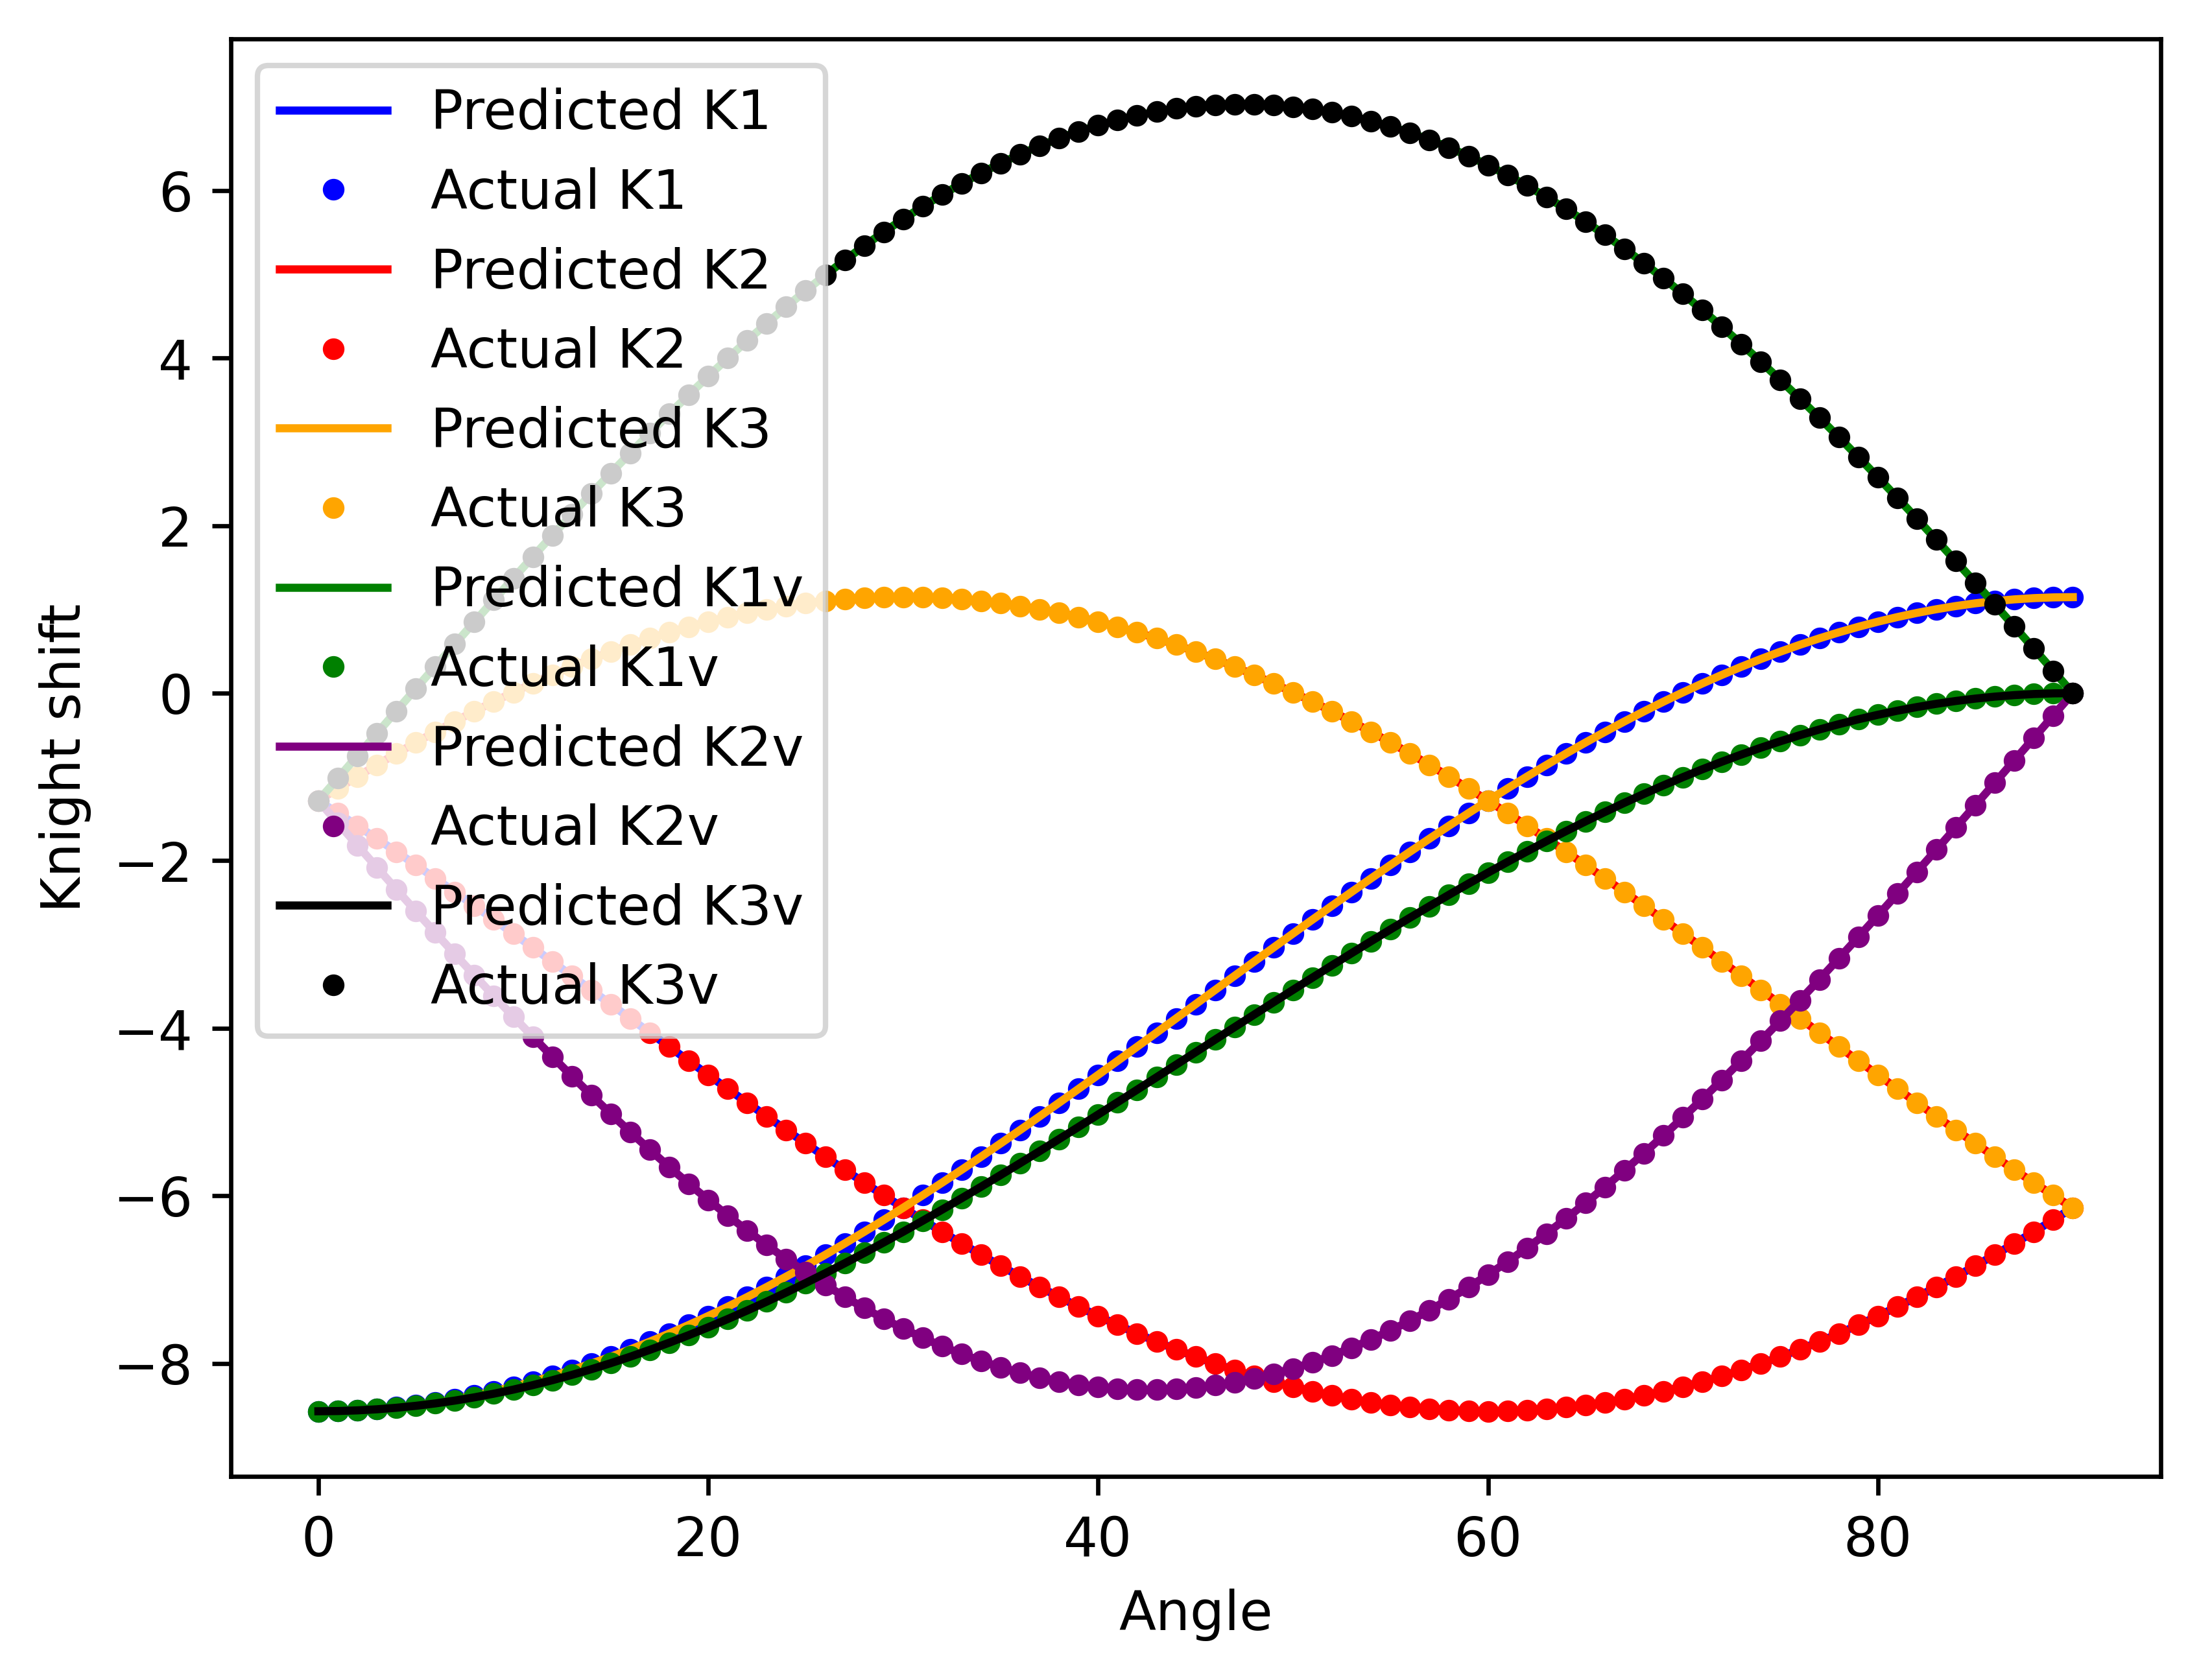

{'k1': 0.6545083522796631, 'k2': -8.080509185791016, 'k3': -2.005382668812672e-07, 'k4': -1.9857678413391113, 'k5': -8.603808403015137, 'k6': 2.1295061111450195, 't1': 0.00011535036173881963, 'p1': 78.83565521240234, 't2': 90.0, 'p2': 42.99644470214844}


In [27]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)